# Quantum Neural Network
Qiskitを使った量子ニューラルネットワーク(QNN)の実装を紹介する。

なお、本notebookの内容はQiskit Documentationの[Machine Learning Tutorials](https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html)の内容を参考にしている。


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, Gradient
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import COBYLA

In [2]:
expval = AerPauliExpectation()
gradient = Gradient()
qi_sv = QuantumInstance(Aer.get_backend('statevector_simulator'))
qi_qasm = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1000)

# 【準備】QiskitにおけるQNNの実装
QNNの構築の方法は、`NeuralNetwork`というインターフェースをベースに、大きく分けると２種類に分けることが出来る

|クラス名|QNNの出力|
|--|--|
|OpflowQNN (TwoLayerQNN)|オブザーバブルの期待値|
|CircuitQNN|測定によるサンプリング|


## OpflowQNN

In [3]:
from qiskit_machine_learning.neural_networks import OpflowQNN

In [4]:
# 演算子の定義
params1 = [Parameter('input1'), Parameter('weight1')]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc_sfn1 = StateFn(qc1)

H1 = StateFn(PauliSumOp.from_list([('Z', 1.0), ('X', 1.0)]))
op1 = ~H1 @ qc_sfn1

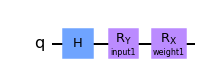

In [5]:
qc1.draw('mpl')

In [6]:
qnn1 = OpflowQNN(op1, [params1[0]], [params1[1]], expval, gradient, qi_sv)

input1 = np.random.rand(qnn1.num_inputs)
weight1 = np.random.rand(qnn1.num_weights)

### 順伝播計算
`OpflowQNN`では演算子の期待値を出力する。

In [7]:
qnn1.forward(input1, weight1)

array([[0.44255585]])

In [8]:
# 順伝播計算は演算子の期待値を出力していることを確認
from qiskit.opflow.converters import CircuitSampler
param_dict = dict(zip(params1, [input1[0], weight1[0]]))
op1_binded = op1.assign_parameters(param_dict)
expectation = expval.convert(op1_binded)
sampler = CircuitSampler(qi_qasm).convert(expectation) 
sampler.eval().real

0.4425558451194765

### 逆伝播計算
`OpflowQNN`では演算子の期待値の関数に対して入力と重みの微分を出力する。

In [9]:
# output: input gradiend, weight gradient
qnn1.backward(input1, weight1)

(array([[[-1.11730987]]]), array([[[0.42448127]]]))

In [10]:
# 逆伝播計算は演算子の期待値関数の入力と重みに対する微分計算であることを確認
state_grad = Gradient(grad_method="param_shift").convert(operator=op1, params=params1)
result = state_grad.assign_parameters(param_dict).eval()
np.array(result).real

array([-1.11730987,  0.42448127])

## 【本題】`OpflowQNN`を使った分類タスク

In [11]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

## データの準備
20個のサンプルについて、$y=-x$ を境界として$y>x$の範囲に存在するか、$y<x$の範囲に存在するかを分類する。

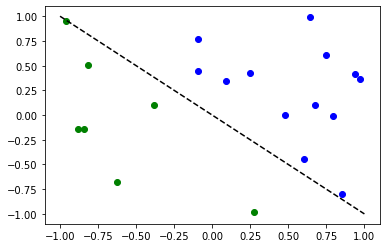

In [12]:
num_inputs = 2
num_samples = 20
X = 2*np.random.rand(num_samples, num_inputs) - 1 # num_sample x num_inpuutsの配列
y01 = 1*(np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2*y01-1                       # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

`OpflowQNN`を使った分類器を構築する。ただし`OpflowQNN`の出力は[-1, +1]での一次元の値であるため、適用可能な分類問題に制約がついてしまう。<br>
そこで今回は`OpflowQNN`を拡張した`TwoLayerQNN`を利用する。

In [13]:
# default observable: Z^n
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=qi_qasm)
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=COBYLA())

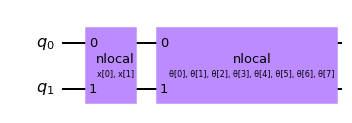

In [14]:
# QNNを構成している量子回路を確認する
opflow_qnn.circuit.draw('mpl')

回路の前半部分はfeature mapと呼ばれる古典データを量子系に読み込むための部分。`TwoLayerOp`のデフォルトではZZ Feature Mapが使用される。
 
$$𝑈_{\Phi(x)} H^{\otimes2} 𝑈_{\Phi(x)} H^{\otimes2}$$

$$\Phi(\bm x)=exp⁡[𝑖(\phi_1(\bm x)ZI+\phi_2(\bm x)IZ+\phi_1,2(\bm x)ZZ)]$$
<!-- $$𝜙_𝑆:𝑥→{(𝑥_𝑖@(𝜋−𝑥_𝑖 )(𝜋−𝑥_𝑗 ) )$$ -->

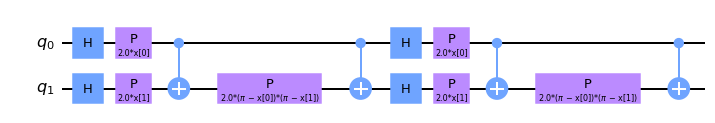

In [15]:
opflow_qnn.feature_map.draw('mpl')

回路の後半部分はansatzと呼ばれるパラメータを調整して適切な学習モデルを構築するための部分。`TwoLayerOp`のデフォルトではRealAmplitudesが使用される。

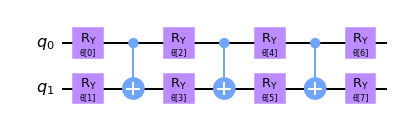

In [16]:
opflow_qnn.ansatz.draw('mpl')

学習させて誤差を評価する

In [17]:
opflow_classifier.fit(X, y)
opflow_classifier.score(X, y)

0.7

得られた学習モデルを使って評価用に生成した100個のサンプルに対して分類を行う。
赤い丸で囲われた点は予測結果が実際の結果とは異なる結果を表すように可視化する。

In [18]:
# 評価用のデータを生成
num_samples_test = 100
X_test = 2*np.random.rand(num_samples_test, num_inputs) - 1 # num_sample x num_inpuutsの配列
y01_test = 1*(np.sum(X_test, axis=1) >= 0)  # in { 0,  1}
y_test = 2*y01_test-1                       # in {-1, +1}

In [19]:
# plot results
def plot_predict_result(X_test, y_test, y_predict):
    for x, y_target, y_p in zip(X_test, y_test, y_predict):
        if y_p == 1:
            plt.plot(x[0], x[1], 'bo')
        else:
            plt.plot(x[0], x[1], 'go')
        if y_target != y_p:
            plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
    plt.plot([-1, 1], [1, -1], '--', color='black')
    plt.show()

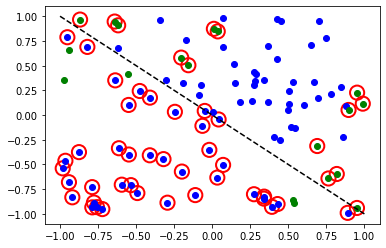

In [20]:
# evaluate data points
y_predict = opflow_classifier.predict(X_test)

plot_predict_result(X_test, y_test, y_predict)

学習モデルがきちんと作れていないのでまずは学習サンプル数を10倍(20→200)に増やしてみる。

In [21]:
num_samples = 200
X2 = 2*np.random.rand(num_samples, num_inputs) - 1 # num_sample x num_inpuutsの配列
y01_2 = 1*(np.sum(X2, axis=1) >= 0)  # in { 0,  1}
y2 = 2*y01_2-1                       # in {-1, +1}

In [22]:
opflow_classifier.fit(X2, y2)
opflow_classifier.score(X2, y2)

0.585

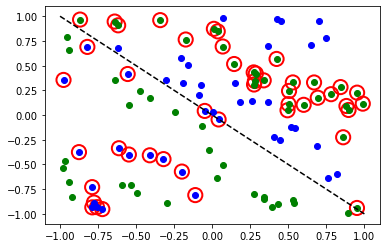

In [23]:
# evaluate data points
y_predict = opflow_classifier.predict(X_test)

plot_predict_result(X_test, y_test, y_predict)

結果は相変わらず予測器としての精度はかなり悪い。最初のfeature mapで複雑なマッピングをしてしまったがゆえに分類しきれていないのかもしれない。<br>
feature mapをシンプルなものに変えてみる。

In [24]:
params2 = [Parameter('test1'), Parameter('test2')]
simple_feature_map = QuantumCircuit(num_inputs)
for i in range(num_inputs):
    simple_feature_map.ry(params2[i], [i])
opflow_qnn2= TwoLayerQNN(num_inputs, feature_map=simple_feature_map, quantum_instance=qi_qasm)

In [25]:
opflow_classifier2 = NeuralNetworkClassifier(opflow_qnn2, optimizer=COBYLA())
opflow_classifier2.fit(X, y)
opflow_classifier2.score(X, y)

0.95

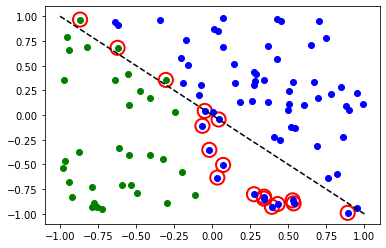

In [26]:
# evaluate data points
y_predict2 = opflow_classifier2.predict(X_test)

# plot results
plot_predict_result(X_test, y_test, y_predict2)

上図のように精度先ほどよりも改善している。このように単に複雑な量子回路を選べば万能に機能するわけではなく、<br>
適切な量子回路の選択がひつようとなることがわかる。

## reference
1. https://medium.com/qiskit/introducing-qiskit-machine-learning-5f06b6597526

## バージョン情報

In [27]:
import qiskit.tools.jupyter
%qiskit_version_table